In [4]:
#install lib for kalman filter calc
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 8.8 MB/s eta 0:00:00


In [5]:
#import libraries

import pandas as pd
import datetime as dt
import warnings
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

warnings.filterwarnings('ignore')

In [6]:
#read data
data = pd.read_parquet('data.parquet')
data

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [37]:
#define variables

weekend = ['Saturday','Sunday']

market_start = dt.time(9, 15)  #market tradin hours
market_end = dt.time(15, 30)

rolling_window = 376
hurst_window = 120

entry=1.00
exit=0.25

In [8]:
#introduce columns for easy data handling

data['date'] = data.index.date
data['time'] = data.index.time
data['day'] = pd.to_datetime(data['date']).dt.day_name()

In [9]:
#remove data on the weekends and non trading market hours

data = data[~data['day'].isin(weekend)]
data_market = data[(data['time'] >= market_start) & (data['time'] <= market_end)]

In [10]:
#handle nan values using forward fill

data_market['banknifty'] = data_market['banknifty'].ffill()
data_market['nifty'] = data_market['nifty'].ffill()

In [11]:
# hurst exponent function
def compute_hurst(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
    hurst = np.polyfit(np.log(lags), np.log(tau), 1)[0]  #the hurst exponent is the slope of line in the regression of log of lags vs log of std deviation of lagged differences
    return hurst

def compute_hurst_values(spread_series):
  hurst_values = []
  for i in range(len(spread_series)):
      if i < hurst_window:
          hurst_values.append(np.nan)
      else:
          window = spread_series[i - hurst_window:i]  #choose appropirate values based on lookback window
          hurst = compute_hurst(window)
          hurst_values.append(hurst)

  return hurst_values

In [12]:
def trade(data_market,strat,rolling_window,hurst_window,entry,exit,include_hurst=False):
  df = data_market.copy(deep=True)

  if(strat=='Kalman'): #kalman filter strategy to compute dynamic hedge ratios
    observations = df['banknifty'].values
    predictors = df['nifty'].values

    # build the Kalman Filter model for y = beta * x + alpha
    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=np.vstack([predictors, np.ones_like(predictors)]).T[:, np.newaxis, :],
        initial_state_mean=[0, 0],
        initial_state_covariance=np.eye(2) * 1e-5,
        observation_covariance=1.0,
        transition_covariance=np.eye(2) * 0.001
    )

    state_means, state_covs = kf.filter(observations)

    # estimate hedge ratio and intercept dynamically
    df['beta'] = state_means[:, 0]
    df['alpha'] = state_means[:, 1]
    df['spread'] = df['banknifty'] - (df['beta'] * df['nifty'] + df['alpha'])  #spread calculation based on kalman filter generated betas

  else:
    df['spread'] = df['banknifty']-df['nifty']

  #calc z scores
  df['spread_mean'] = df['spread'].rolling(rolling_window).mean()
  df['spread_std'] = df['spread'].rolling(rolling_window).std()
  df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']  #zscore calculation



  if(include_hurst):  #calc hurst values

    df['hurst'] = compute_hurst_values(df['spread'].values)
    entry_condition = df['hurst'] < 0.5  # only trade in mean-reverting regime

  else:
    entry_condition = True

  df['signal'] = 0  #initial all signals 0

  df.loc[(df['z_score'] > entry) & entry_condition, 'signal'] = -1  # short spread
  df.loc[(df['z_score'] < -entry) & entry_condition, 'signal'] = +1  # long spread


  df['position'] = 0
  position = 0

  #hold position until exit signal
  for i in range(1, len(df)):
    if df['signal'].iloc[i] != 0:
      position = df['signal'].iloc[i]
    elif abs(df['z_score'].iloc[i]) < exit:
      position = 0
    df.at[df.index[i], 'position'] = position

  # calc pnl
  df['spread_change'] = df['spread'].diff().shift(-1)  # spread_t+1 - spread_t
  df['pnl'] = df['spread_change'] * df['position'] * (df['tte'] ** 0.7) #use position , spread of the next day and tte to calculate pnl


  df['pnl'].fillna(0, inplace=True)
  df['cum_pnl'] = df['pnl'].cumsum() #profits are added, assuming equal poisiton taken per trade

  return df

In [13]:
def calc_metrics(df):
  capital = 100000  # assumed capital per trade in rupees
  df['daily_return'] = df['pnl'] / capital  # return per unit capital

  # sharpe ratio (annualized from daily returns)
  sharpe = (df['daily_return'].mean()) / (df['daily_return'].std()) * np.sqrt(250)

  # max drawdown
  cum_pnl = df['cum_pnl']
  running_max = cum_pnl.cummax()
  drawdown = (running_max - cum_pnl)
  max_drawdown = drawdown.max()

  # trade occurs when position changes from 0 → +1 or 0 → -1
  trade_entries = df[(df['position'] != 0) & (df['position'].shift(1) == 0)]

  # summary
  print(f"Sharpe Ratio: {sharpe:.2f}")
  print(f"Max Drawdown: {max_drawdown:.4f}")
  print(f"Total P&L: {df['cum_pnl'].iloc[-1]:.4f}")
  print(f"Number of trades: {len(trade_entries)}")

  df['cum_pnl'].plot(figsize=(12, 5), title='Cumulative P&L of Z-Score Volatility Pairs Strategy')
  plt.grid(True)
  plt.show()


Sharpe Ratio: 1.28
Max Drawdown: 0.8989
Total P&L: 349.5090
Number of trades: 4377


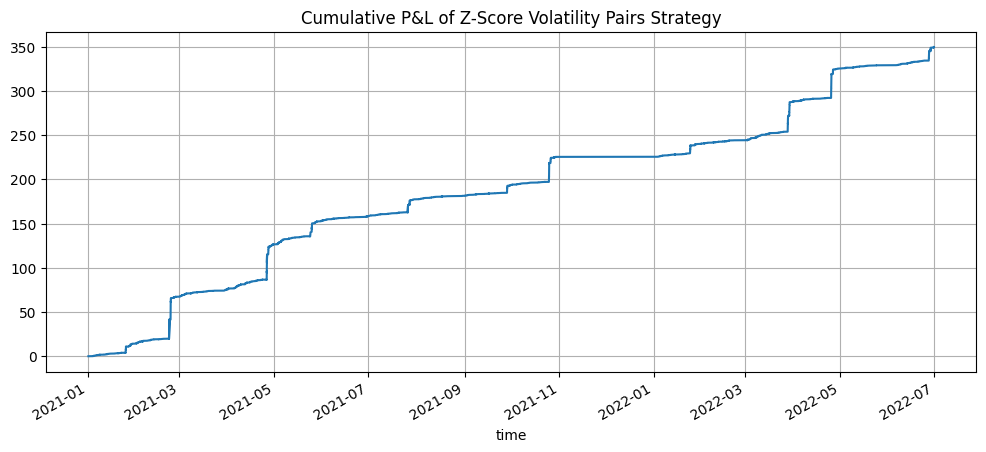

In [38]:
calc_metrics(trade(data_market,'Kalman',rolling_window,hurst_window,entry,exit,include_hurst=True))